# Установка зависимостей

In [ ]:
!pip install -U torch torchvision
import numpy as np
import pandas as pd
import math
import random
import pickle
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool

import torch
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torch.nn as nn

from matplotlib import colors, pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

Проверим доступен ли GPU:

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = torch.device("cpu")
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = torch.device("cuda")

In [ ]:
!nvidia-smi

Константы:

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

#количество эпох
EPOCHES = 10

Ниже мы исспользуем враппер над датасетом для удобной работы. 

ToTensor конвертирует PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1], затем производится масштабирование:  $input = \frac{input - \mu}{\text{standard deviation}} $

константы - средние и дисперсии по каналам на основе ImageNet

Переопределяем метод getitem для удобства работы.

Используем LabelEncoder для преобразования строковых меток классов в id и обратно. 

Картинки разного размера, так как брались напрямую с видео, поэтому приводим их к одному размеру (метод _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Path - это объект из библиотеки pathlib, который представляет путь к файлу или директории в операционной системе.

TRAIN_DIR и TEST_DIR это переменные которые содержат пути к директориям с данными обучения и тестирования. 
train_val_files список файлов обучающего набора данных с расширением .jpg в алфавитном порядке.
test_files аналогично для тестового набора.


In [ ]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train') 
TEST_DIR = Path('/kaggle/input/journey-springfield/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Создаем список лейблов

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]

Разобьём выборку на тестовую и валидационную

In [ ]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Посмотрим героев внутри датасета.

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Draft version

Простая свёрточная нейросеть

Описание слоёв:

1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
model = simple_cnn
print("we will classify :{}".format(n_classes))
print(simple_cnn)

## Обучение

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=EPOCHES, batch_size=64)

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Предсказание

Переведем сеть в режим предсказания и получить вектор вероятностей того, что объект относится к тому или иному классу.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
   """Предсказание, для одной картинки"""
   with torch.no_grad():
       inputs = inputs.to(device)
       model.eval()
       logit = model(inputs).cpu()
       probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
   return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

## F-1 score

Метрика, которую необходимо оптимизировать в конкурсе - f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
f1_score(actual_labels, y_pred, average="micro")

## Submit #1

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('/kaggle/working/simple_nn_submission.csv', index=False)

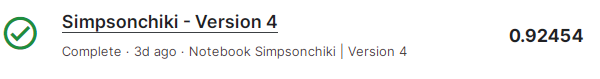

# EfficientNet

## Архитектура

> EfficientNet-B0, была разработана авторами, искавшими архитектуру сети, оптимизирующую как точность, так и требуемое количество вычислений. Основной строительный блок EfficientNet-B0 – это MBConv (мобильная обращенная свертка с узким местом), к которой добавлено сжатие-и-стимуляция.
>
>В традиционном ResBlock'е количество каналов следует образцу широкое-узкое-широкое (также называемое "узким местом"), параллельно с обходной связью идентичности. Вход имеет большое количество каналов, сжимаемых сверткой 1х1. Затем количество опять увеличивается сверткой 1х1, чтобы можно было прибавить данные по связи идентичности.
>
>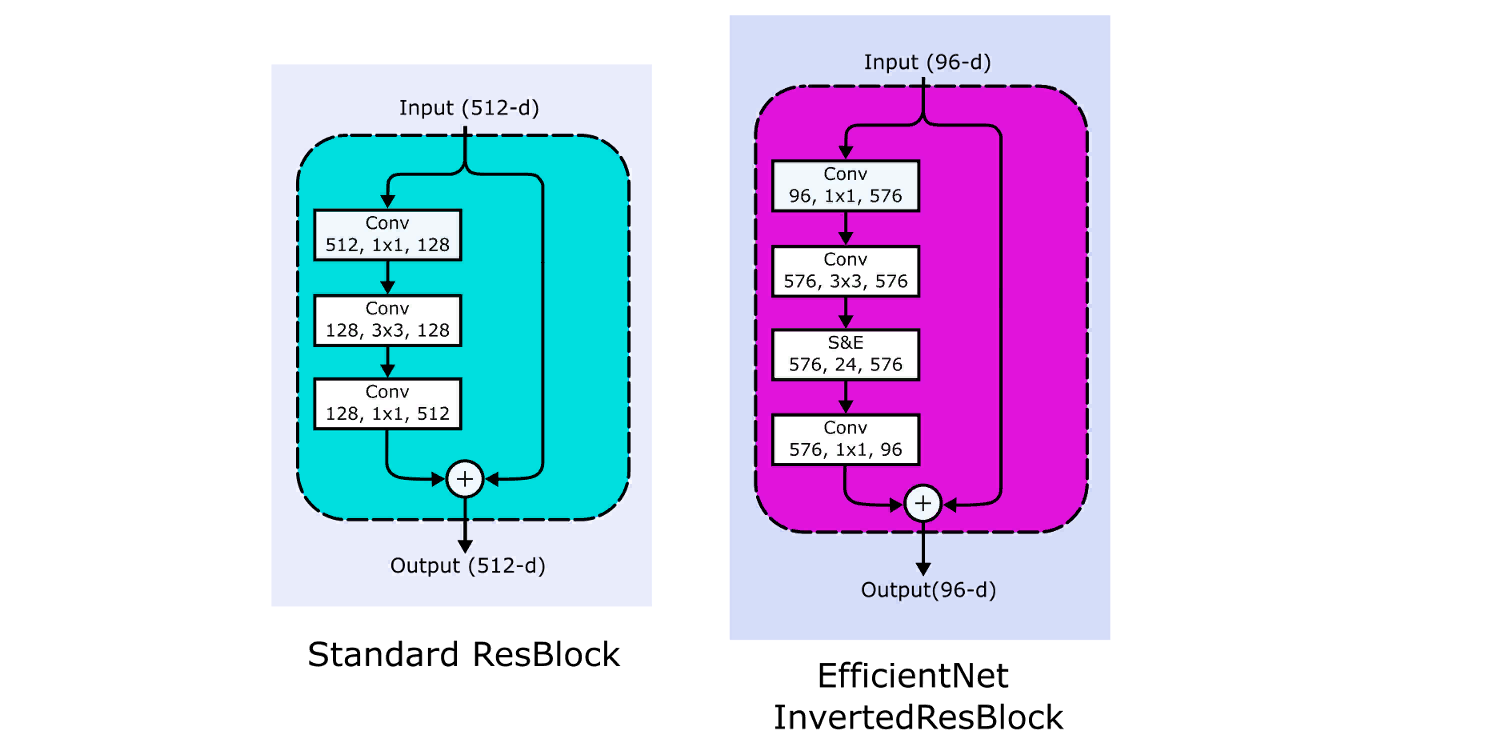
>
> Инвертированный остаточный блок (Inverted Residual Block), как и предполагает его название, использует подход узкий/широкий/узкий. Плоский вход расширяется сверткой 1*1 перед применением глубинной свертки 3*3, сильно сокращающей количество параметров. Затем снова используется свертка 1*1 для сокращения количества каналов, чтобы можно было прибавить данные по связи идентичности.
>
>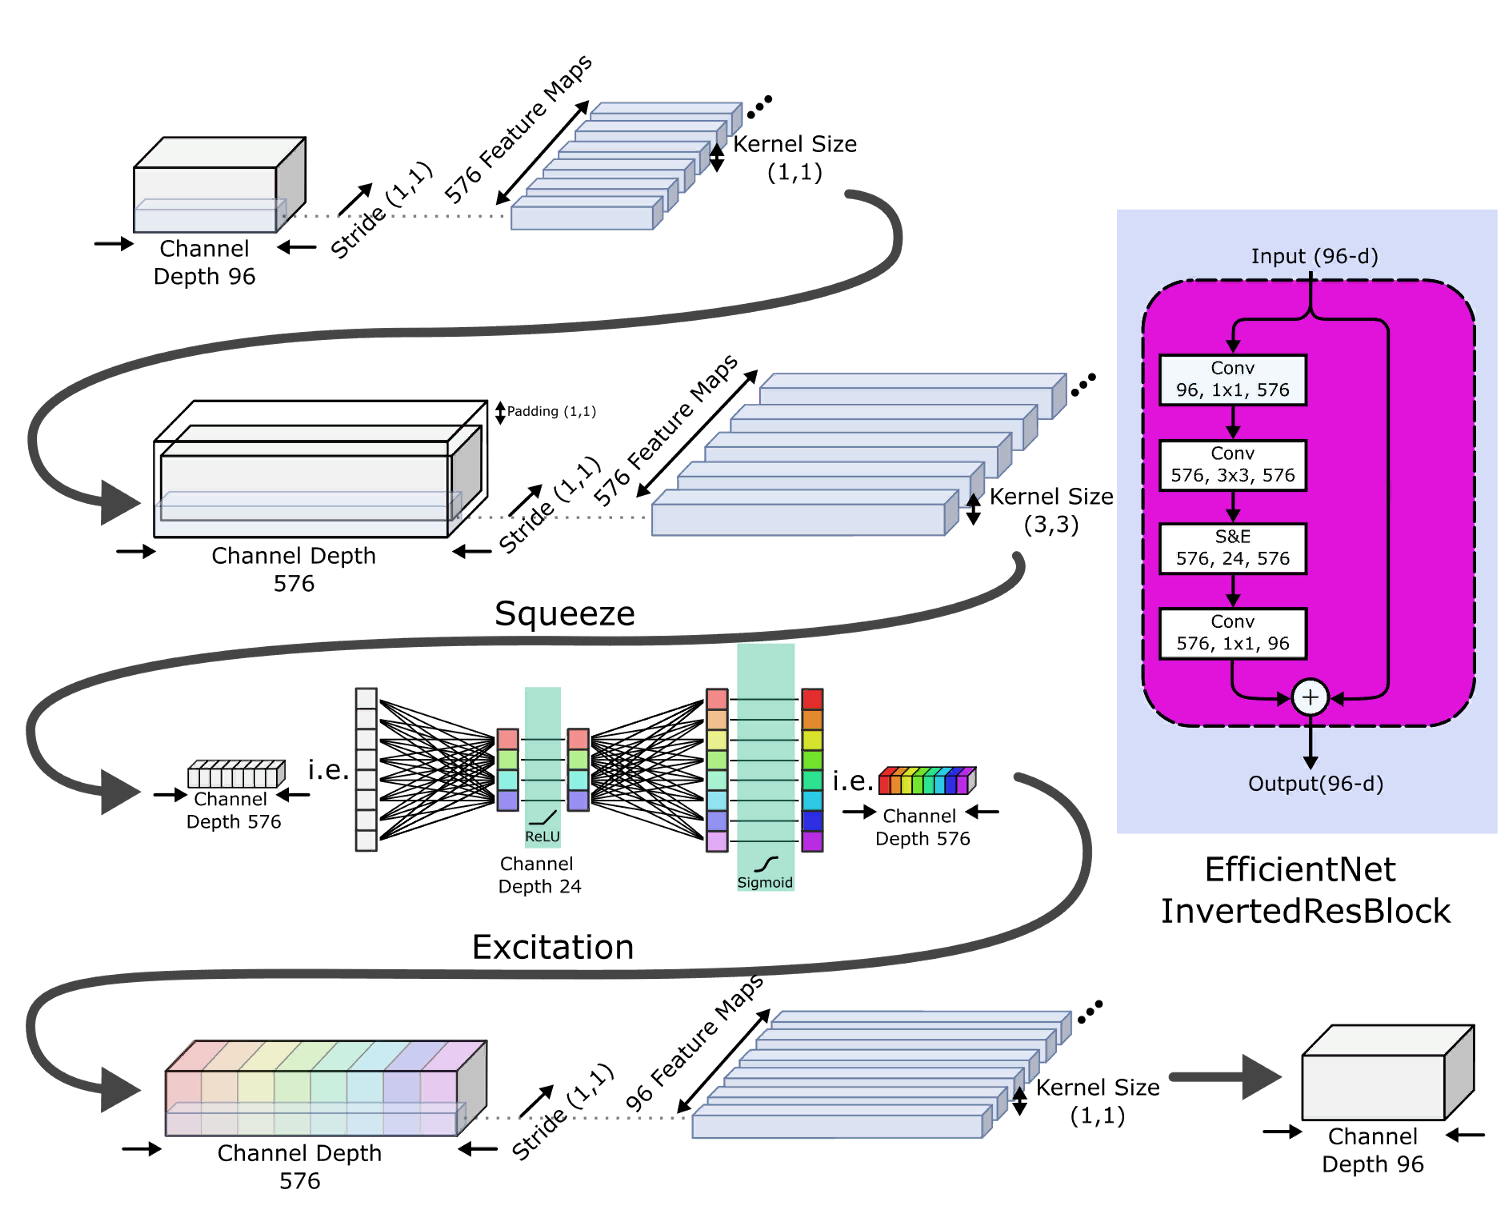
>
>Эта структура уменьшает общее количество операций и размер модели, что позволяет EfficientNet-B0 иметь точность Топ-5, сравнимую с точностью ResNet-34, несмотря на то, что у нее вчетверо меньше тренируемых параметров, и ее обучение требует на порядок меньше вычислительных операций.

Взято [отсюда](https://proglib.io/p/issleduem-arhitektury-svertochnyh-neyronnyh-setey-s-pomoshchyu-fast-ai-2020-12-28)

Но ниже используем EfficientNet-B2

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torchvision import models
n_classes = len(np.unique(train_val_labels))

efficientnet_b2 = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1, progress=True)

for param in efficientnet_b2.parameters():
    param.requires_grad = True

efficientnet_b2.classifier = nn.Sequential(
    nn.Linear(1408, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, n_classes)
)

efficientnet_b2.to(DEVICE)
model = efficientnet_b2

## Обучение

Запустим обучение сети.

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=EPOCHES, batch_size=64)

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Предсказание

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
   """Предсказание, для одной картинки"""
   with torch.no_grad():
       inputs = inputs.to(device)
       model.eval()
       logit = model(inputs).cpu()
       probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
   return probs

ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 200)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

## F-1 score

In [ ]:
f1_score(actual_labels, y_pred, average="micro")

## Submit #2

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('/kaggle/working/efficientnet_b2_submission.csv', index=False)

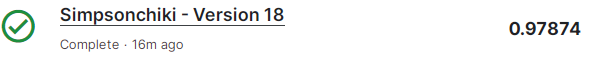

# Аугментация

Посмотрим для кого у нас меньше всего данных

In [ ]:
torch.cuda.empty_cache()

In [ ]:
counts = pd.Series(train_val_labels).value_counts()
labels = list(set(train_val_labels))
plt.figure(figsize=(15, 9))
plt.barh(labels, counts[labels])

Видим, что классы сильно несбалансированы. Будем использовать аугментацию, но для некоторых персонажей крайне мало картинок, их лучше добавить вручную


Скопируем данные в выходную директорию, чтобы мы могли сохранять картинки 

In [ ]:
!cp -r "../input/journey-springfield" "./"

In [ ]:
data = counts.to_frame('count')
data['to_add'] = data['count'].apply(lambda x: 1500 - x if x < 1500 else 0)
data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)

data

Колонка "to_add" показывает сколько картинок нужно добавить, чтобы их стало 1500

Колонка "one_iteration" показывает сколько нужно добавить за одну итерацию  

Будем использовать три типа преобразования:
* RandomCrop - обрезка
* RandomRotation - поворот
* RandomHorizontalFlip - горизонтальное отзеркаливание 

In [ ]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}

In [ ]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

In [ ]:
n_examples = 3

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = load_image(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name

    img_label = " ".join(map(lambda x: x.capitalize(),\
                img_label.split('_')))
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

In [ ]:
TRAIN_DIR = Path('/kaggle/working/journey-springfield/train/simpsons_dataset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    # if we don't need to add any images, we can continue without transformation
    if data.loc[character]['to_add'] <= 0:
        continue

    # if number of images to create for one iteration is greater than the rest of images to create,
    # we should use 'to_add' instead of 'one_iteration'  
    if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:
        iter_size = data.loc[character]['to_add']
    else:
        iter_size = data.loc[character]['one_iteration']
    data.loc[character]['to_add'] -= iter_size
    
    for i in range(iter_size):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

In [ ]:
!zip -r "journey-springfield-augmented.zip" . > /dev/null

## Результаты аугментации

Посмотрим, как теперь распределены данные

In [ ]:
aug_files = list(TRAIN_DIR.rglob('*.jpg'))
aug_labels = [path.parent.name for path in aug_files]
aug_counts = pd.Series(aug_labels).value_counts()

plt.figure(figsize=(15, 9))
plt.barh(labels, aug_counts[labels])

## Обучение

Разобьём выборку на тестовую и валидационную и запустим обучение

In [ ]:
train_files, val_files = train_test_split(aug_files, test_size=0.25, \
                                          stratify=aug_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=EPOCHES, batch_size=64)

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Предсказание

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
   """Предсказание, для одной картинки"""
   with torch.no_grad():
       inputs = inputs.to(device)
       model.eval()
       logit = model(inputs).cpu()
       probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
   return probs

ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 200)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

## F-1 score 

In [ ]:
f1_score(actual_labels, y_pred, average="micro")

## Submit #3

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('/kaggle/working/efficientnet_aug_submission.csv', index=False)

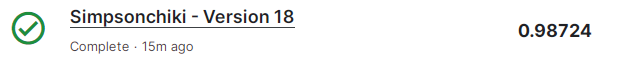

# Визуализация уверенности сети

Сделаем визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах.

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Заключение 

Лучший результат по F-1 метрике получился 0,987 при использовании EfficientNet и аугментации. Для повышения этого результата можно добавить картинок тех персонажей, которых в обучающей выборке до аугументации было очень мало, например, для lionel_hutz их всего 3. 